In [1]:
# 📊 Referee Adjustment Factor (RAF) Notebook
# This notebook demonstrates how to calculate various referee performance and bias metrics 
# to compute the Referee Adjustment Factor (RAF) using the mock dataset.

# -----------------------------
# 📦 1. Import Libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# -----------------------------
# 📂 2. Load Dataset
# -----------------------------
df = pd.read_csv('/Users/jamescrummack/football_RAF_project/mock_referee_raf_dataset.csv')
df.head()

# -----------------------------
# 📈 3. Calculate Referee Behavior Metrics
# -----------------------------
# Group by referee to calculate core stats
ref_stats = df.groupby('Referee').agg({
    'Fouls_Home': 'mean',
    'Fouls_Away': 'mean',
    'Cards_Home': 'mean',
    'Cards_Away': 'mean',
    'Pens_Home': 'mean',
    'Pens_Away': 'mean',
    'VAR_Overturns': 'mean',
    'VAR_Missed': 'mean',
    'VAR_Reviews': 'mean',
    'Avg_Review_Time': 'mean',
    'VAR_Acceptance_Rate': 'mean'
}).reset_index()

# Additional metrics
ref_stats['Total_Fouls'] = ref_stats['Fouls_Home'] + ref_stats['Fouls_Away']
ref_stats['Total_Cards'] = ref_stats['Cards_Home'] + ref_stats['Cards_Away']
ref_stats['Total_Pens'] = ref_stats['Pens_Home'] + ref_stats['Pens_Away']
ref_stats['Overturn_Rate'] = ref_stats['VAR_Overturns'] / ref_stats['VAR_Reviews']
ref_stats['Miss_Rate'] = ref_stats['VAR_Missed'] / ref_stats['VAR_Reviews']
ref_stats = ref_stats.fillna(0)

ref_stats.head()

# -----------------------------
# 📊 4. Normalize Metrics with Z-Scores
# -----------------------------
metrics_to_normalize = [
    'Total_Fouls', 'Total_Cards', 'Total_Pens',
    'Overturn_Rate', 'Miss_Rate', 'Avg_Review_Time'
]

for metric in metrics_to_normalize:
    ref_stats[f'{metric}_Z'] = zscore(ref_stats[metric])

ref_stats.head()

# -----------------------------
# 🧮 5. Calculate RAF Score
# -----------------------------
# Weighted average of normalized metrics (weights are tunable)
ref_stats['RAF_Score'] = (
    0.2 * ref_stats['Total_Fouls_Z'] +
    0.2 * ref_stats['Total_Cards_Z'] +
    0.2 * ref_stats['Total_Pens_Z'] +
    0.2 * ref_stats['Overturn_Rate_Z'] +
    0.1 * ref_stats['Miss_Rate_Z'] +
    0.1 * ref_stats['Avg_Review_Time_Z']
)

# -----------------------------
# 📋 6. View and Rank Referees by RAF
# -----------------------------
ref_stats[['Referee', 'RAF_Score']].sort_values(by='RAF_Score', ascending=False)


,Referee,RAF_Score
0,Anthony Taylor,0.827356
2,Michael Oliver,0.770105
4,Paul Tierney,-0.017707
1,Craig Pawson,-0.596913
3,Mike Dean,-0.982840


In [2]:
# -----------------------------------
# 📊 RTBI: Referee-Team Bias Index
# -----------------------------------

# Merge referee averages (ref_stats) into main match dataframe
# We'll reuse the metrics already computed in `ref_stats`

metrics_for_bias = [
    'Fouls_Home', 'Fouls_Away',
    'Cards_Home', 'Cards_Away',
    'Pens_Home', 'Pens_Away',
    'VAR_Overturns', 'VAR_Missed', 'VAR_Reviews'
]

ref_avg_map = ref_stats[['Referee']].copy()
for metric in metrics_for_bias:
    ref_avg_map[f'RefAvg_{metric}'] = df.groupby('Referee')[metric].mean().values

# Merge into df
df = df.merge(ref_avg_map, on='Referee', how='left')

# Function to compute match-by-match bias values
def compute_bias(row, team_col, foul_col, card_col, pen_col):
    return pd.Series({
        'Team': row[team_col],
        'Foul_Bias': row[foul_col] - row[f'RefAvg_{foul_col}'],
        'Card_Bias': row[card_col] - row[f'RefAvg_{card_col}'],
        'Pen_Bias': row[pen_col] - row[f'RefAvg_{pen_col}'],
        'Overturn_Bias': row['VAR_Overturns'] - row['RefAvg_VAR_Overturns'],
        'Miss_Bias': row['VAR_Missed'] - row['RefAvg_VAR_Missed']
    })

# Apply to both home and away teams
home_bias = df.apply(lambda row: compute_bias(row, 'Home_Team', 'Fouls_Home', 'Cards_Home', 'Pens_Home'), axis=1)
away_bias = df.apply(lambda row: compute_bias(row, 'Away_Team', 'Fouls_Away', 'Cards_Away', 'Pens_Away'), axis=1)

# Combine, group, and average per team
team_bias_df = pd.concat([home_bias, away_bias])
team_rtbi = team_bias_df.groupby('Team').mean().reset_index()

# Display RTBI table
team_rtbi.sort_values(by='Foul_Bias', ascending=True)

,Team,Foul_Bias,Card_Bias,Pen_Bias,Overturn_Bias,Miss_Bias
4,Liverpool,-0.642958,-0.260437,-0.083063,0.087113,0.087361
3,Leicester,-0.383950,-0.273666,0.019319,0.055717,0.109102
7,Newcastle,-0.383392,-0.032688,0.209802,0.060398,0.122248
2,Leeds,-0.255737,-0.143173,-0.064719,-0.149547,-0.111384
8,Spurs,-0.186854,0.308320,-0.079708,-0.014679,0.027084
9,West Ham,0.144984,-0.120103,-0.003893,-0.019363,-0.091479
0,Arsenal,0.163147,-0.090185,-0.042832,-0.038001,-0.176715
5,Man City,0.265886,0.386870,0.089648,-0.036445,-0.009002
1,Chelsea,0.596811,0.015370,0.030350,0.006689,0.056705
6,Man United,0.669039,0.084203,0.016962,0.176590,0.137371


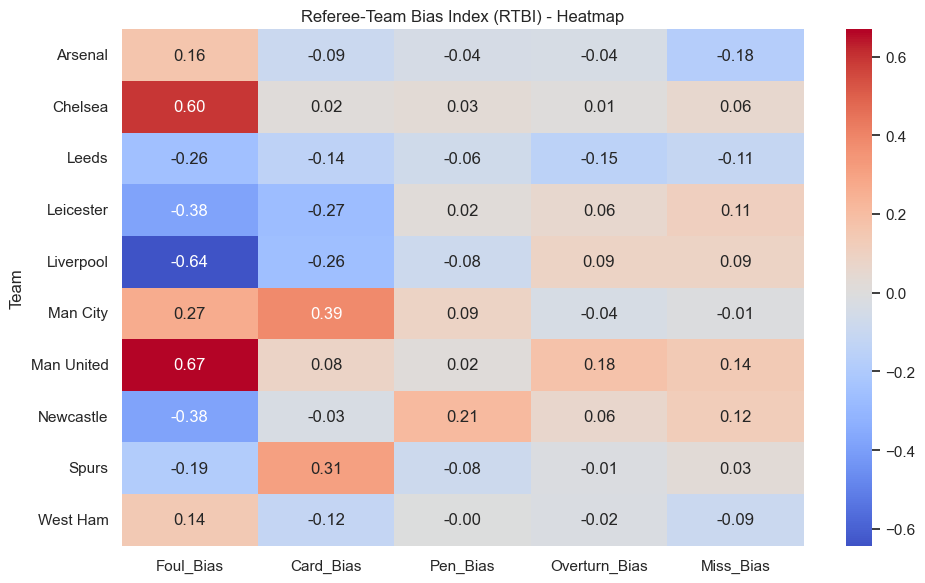

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# -----------------------
# 📉 Heatmap of RTBI Biases
# -----------------------
plt.figure(figsize=(10, 6))
heatmap_data = team_rtbi.set_index('Team')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Referee-Team Bias Index (RTBI) - Heatmap")
plt.tight_layout()
plt.show()

In [6]:
import ipywidgets as widgets
from IPython.display import display

# Dropdown widget for selecting a team
team_dropdown = widgets.Dropdown(
    options=team_rtbi['Team'].unique(),
    description='Select Team:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Radar chart plotting function
def update_radar_chart(team_name):
    team_data = team_rtbi[team_rtbi['Team'] == team_name].drop(columns=['Team']).values.flatten().tolist()
    labels = team_rtbi.columns[1:].tolist()
    
    num_vars = len(labels)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    team_data += team_data[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, team_data, linewidth=2, linestyle='solid')
    ax.fill(angles, team_data, alpha=0.4)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f"RTBI Radar Chart: {team_name}", size=14)
    plt.show()

# Create interactive radar chart
widgets.interact(update_radar_chart, team_name=team_dropdown)

interactive(children=(Dropdown(description='Select Team:', layout=Layout(width='50%'), options=('Arsenal', 'Ch…

<function __main__.update_radar_chart(team_name)>